
# A Notebook to TreatGeoSelf with gridded climate time-series data sets

## (Case study:  the Sauk-Suiattle river watershed, the Elwha river watershed, the Upper Rio Salado watershed)

<img src= "http://www.sauk-suiattle.com/images/Elliott.jpg"
style="float:left;width:150px;padding:20px">   
This data is compiled to digitally observe the watersheds, powered by HydroShare. <br />
<br />
Use this Jupyter Notebook to: <br /> 
Generate a list of available gridded data points in your area of interest, <br /> 
Download Livneh daily 1/16 degree gridded climate data, <br /> 
Download WRF daily 1/16 degree gridded climate data, <br /> 
Summarize the elevation range and data availability within the watershed areas, <br /> 
Visualize the elevation gradient within the watershed areas. <br /> 

<br /> <br /> <br /> <img src="https://www.washington.edu/brand/files/2014/09/W-Logo_Purple_Hex.png" style="float:right;width:120px;padding:20px">  
#### A Watershed Dynamics Model by the Watershed Dynamics Research Group in the Civil and Environmental Engineering Department at the University of Washington 

## 1.  HydroShare Setup and Preparation

To run this notebook, we must import several libaries. These are listed in order of 1) Python standard libraries, 2) hs_utils library provides functions for interacting with HydroShare, including resource querying, dowloading and creation, and 3) the observatory_gridded_hydromet library that is downloaded with this notebook. 

If the python library basemap-data-hires is not installed, please uncomment and run the following lines in terminal.

In [1]:
#!conda install -c conda-forge basemap-data-hires graphviz python-graphviz pygraphviz networkx --yes

In [2]:
# data processing
import os
import pandas as pd, numpy as np, dask, json
from utilities import hydroshare
import ogh
import geopandas as gpd

# plotting and shape libraries
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [3]:
# initialize ogh_meta
meta_file = dict(ogh.ogh_meta())
sorted(meta_file.keys())

['dailymet_bclivneh2013',
 'dailymet_livneh2013',
 'dailymet_livneh2015',
 'dailyvic_livneh2013',
 'dailyvic_livneh2015',
 'dailywrf_bcsalathe2014',
 'dailywrf_salathe2014']

In [4]:
sorted(meta_file['dailymet_livneh2013'].keys())

['decision_steps',
 'delimiter',
 'domain',
 'end_date',
 'file_format',
 'filename_structure',
 'reference',
 'spatial_resolution',
 'start_date',
 'subdomain',
 'temporal_resolution',
 'variable_info',
 'variable_list',
 'web_protocol']

Establish a secure connection with HydroShare by instantiating the hydroshare class that is defined within hs_utils. In addition to connecting with HydroShare, this command also sets and prints environment variables for several parameters that will be useful for saving work back to HydroShare. 

In [5]:
notebookdir = os.getcwd()

hs=hydroshare.hydroshare()
homedir = hs.getContentPath(os.environ["HS_RES_ID"])
os.chdir(homedir)
print('Data will be loaded from and save to:'+homedir)

Adding the following system variables:
   HS_USR_NAME = jphuong
   HS_RES_ID = 7c3416535ab24d4f93b0b94741bb9572
   HS_RES_TYPE = compositeresource
   JUPYTER_HUB_IP = jupyter.cuahsi.org

These can be accessed using the following command: 
   os.environ[key]

   (e.g.)
   os.environ["HS_USR_NAME"]  => jphuong

The hs_utils library requires a secure connection to your HydroShare account.
Enter the HydroShare password for user 'jphuong': ········
Successfully established a connection with HydroShare
Data will be loaded from and save to:/home/jovyan/work/notebooks/data/7c3416535ab24d4f93b0b94741bb9572/7c3416535ab24d4f93b0b94741bb9572/data/contents


If you are curious about where the data is being downloaded, click on the Jupyter Notebook dashboard icon to return to the File System view.  The homedir directory location printed above is where you can find the data and contents you will download to a HydroShare JupyterHub server.  At the end of this work session, you can migrate this data to the HydroShare iRods server as a Generic Resource. 

## 2. Get list of gridded climate points for the watershed

This example uses a shapefile with the watershed boundary of the Sauk-Suiattle Basin, which is stored in HydroShare at the following url: https://www.hydroshare.org/resource/c532e0578e974201a0bc40a37ef2d284/. 

The data for our processing routines can be retrieved using the getResourceFromHydroShare function by passing in the global identifier from the url above.  In the next cell, we download this resource from HydroShare, and identify that the points in this resource are available for downloading gridded hydrometeorology data, based on the point shapefile at https://www.hydroshare.org/resource/ef2d82bf960144b4bfb1bae6242bcc7f/, which is for the extent of North America and includes the average elevation for each 1/16 degree grid cell.  The file must include columns with station numbers, latitude, longitude, and elevation. The header of these columns must be FID, LAT, LONG_, and ELEV or RASTERVALU, respectively. The station numbers will be used for the remainder of the code to uniquely reference data from each climate station, as well as to identify minimum, maximum, and average elevation of all of the climate stations.  The webserice is currently set to a URL for the smallest geographic overlapping extent - e.g. WRF for Columbia River Basin (to use a limit using data from a FTP service, treatgeoself() would need to be edited in observatory_gridded_hydrometeorology utility). 

In [6]:
"""
1/16-degree Gridded cell centroids
"""
# List of available data
hs.getResourceFromHydroShare('ef2d82bf960144b4bfb1bae6242bcc7f')
NAmer = hs.content['NAmer_dem_list.shp']

"""
Sauk
"""
# Watershed extent
hs.getResourceFromHydroShare('c532e0578e974201a0bc40a37ef2d284')
sauk = hs.content['wbdhub12_17110006_WGS84_Basin.shp']

"""
Elwha
"""
# Watershed extent
hs.getResourceFromHydroShare('4aff8b10bc424250b3d7bac2188391e8', )
elwha = hs.content["elwha_ws_bnd_wgs84.shp"]

"""
Rio Salado
"""
# Watershed extent
hs.getResourceFromHydroShare('5c041d95ceb64dce8eb85d2a7db88ed7')
riosalado = hs.content['UpperRioSalado_delineatedBoundary.shp']


This resource already exists in your userspace.
Would you like to overwrite this data [Y/n]? y
Download Finished                               
Successfully downloaded resource ef2d82bf960144b4bfb1bae6242bcc7f


This resource already exists in your userspace.
Would you like to overwrite this data [Y/n]? y
Download Finished                               
Successfully downloaded resource c532e0578e974201a0bc40a37ef2d284


This resource already exists in your userspace.
Would you like to overwrite this data [Y/n]? y
Download Finished                               
Successfully downloaded resource 4aff8b10bc424250b3d7bac2188391e8


This resource already exists in your userspace.
Would you like to overwrite this data [Y/n]? y
Download Finished                               
Successfully downloaded resource 5c041d95ceb64dce8eb85d2a7db88ed7


## visualize the watersheds

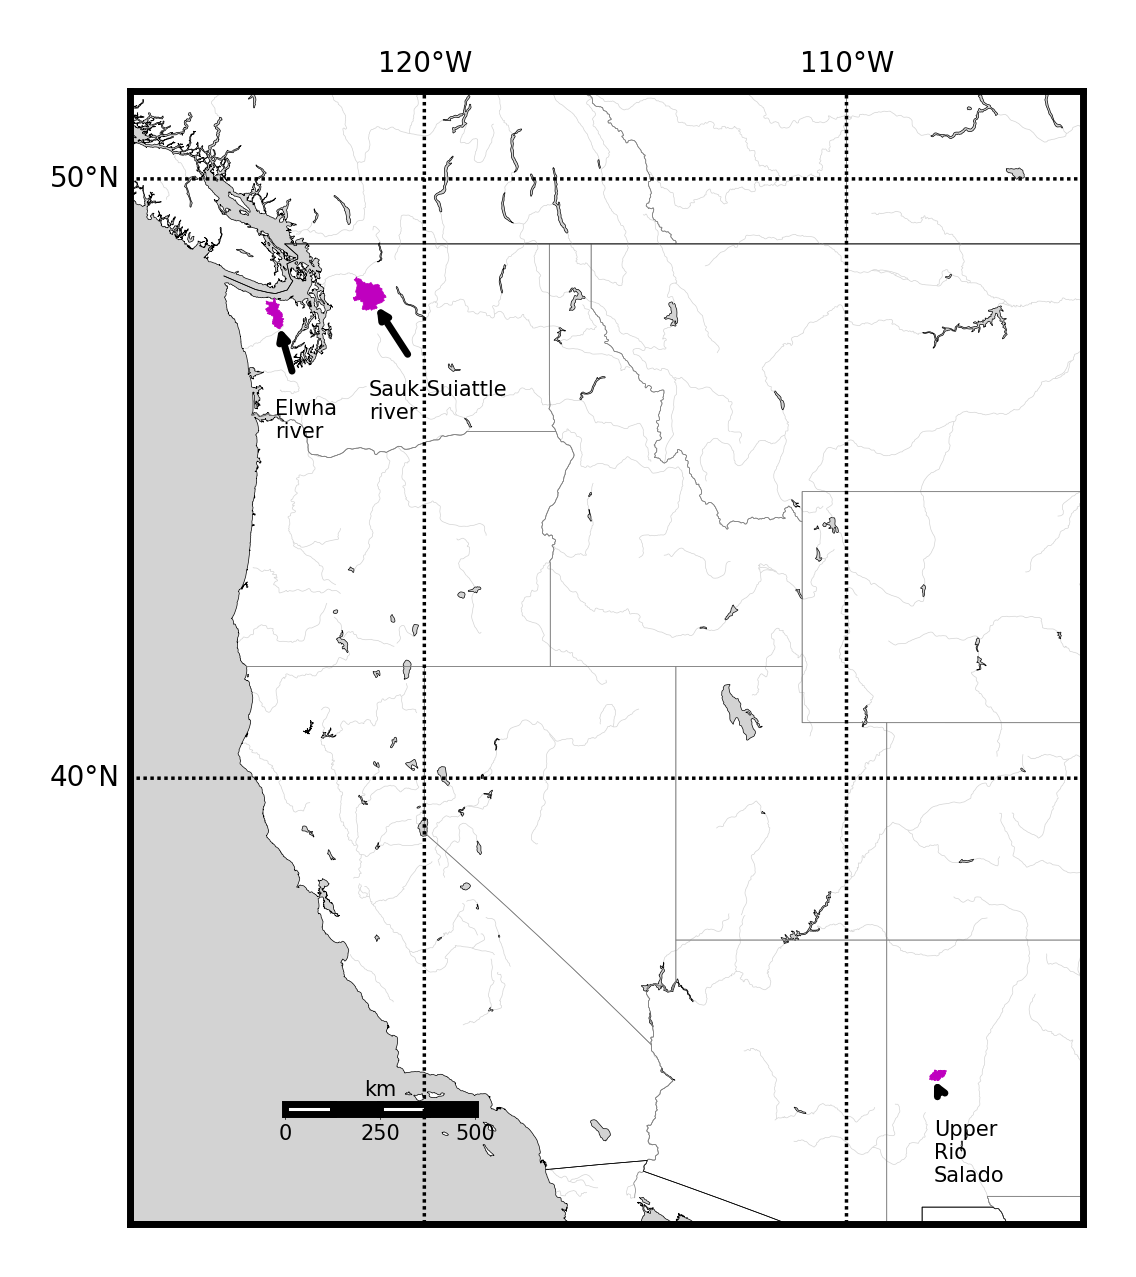

In [7]:
# w1 = ogh.multiSiteVisual(listOfShapefiles=[sauk], listOfNames=['Sauk-Suiattle river'],
#                          multishape='eachwatershed.shp',
#                          singleshape='allwatersheds.shp', 
#                          fileoutpath='annotated_map.png',
#                          projection='merc', epsg=3857, polygon_color='m', margin=1, 
#                          scale_x_dist=0, scale_y_dist=-0.35, scale_ref_length=75, scale_yoffset=5000,
#                          text_x_dist=0, text_y_dist=0.35)

# w1 = ogh.multiSiteVisual(listOfShapefiles=[elwha], listOfNames=['Elwha river'],
#                          multishape='eachwatershed.shp', 
#                          singleshape='allwatersheds.shp', 
#                          fileoutpath='annotated_map.png',
#                          projection='merc', epsg=3857, polygon_color='m', margin=0.75,
#                          scale_x_dist=0, scale_y_dist=-0.35, scale_ref_length=50, scale_yoffset=5000,
#                          text_x_dist=0, text_y_dist=0.35)

w1 = ogh.multiSiteVisual(listOfShapefiles=[sauk, elwha, riosalado],
                         listOfNames=['Sauk-Suiattle river','Elwha river','Upper Rio Salado'],
                         multishape=os.path.join(homedir, 'eachwatershed.shp'),
                         singleshape=os.path.join(homedir, 'allwatersheds.shp'),
                         fileoutpath=os.path.join(homedir, 'annotated_map.png'),
                         projection='merc', epsg=3857, polygon_color='m', margin=0.2, 
                         scale_x_dist=-1, scale_y_dist=-12.5, scale_ref_length=500, scale_yoffset=25000,
                         text_x_dist=0, text_y_dist=-2)

In [8]:
# %%time

# for shp, outfilename in zip([sauk, elwha, riosalado], ['vulner_s.png', 'vulner_e.png', 'vulner_r.png']):

#     # consider coverage of areas with high social vulnerability index
#     ogh.renderWatershed(shp, outfilepath=os.path.join(homedir,outfilename), epsg=3857, margin=0.5,
#                         basemap_image='Demographics/USA_Social_Vulnerability_Index')

## Map the Gridded Cell Centroids that intersect with the watersheds of interest

In [9]:
%%time 
# Generate list of stations to download
mappingfile1=ogh.treatgeoself(shapefile=sauk, NAmer=NAmer, buffer_distance=0.06,
                              mappingfile=os.path.join(homedir,'Sauk_mappingfile.csv'))
print(mappingfile1)


mappingfile2=ogh.treatgeoself(shapefile=elwha, NAmer=NAmer, buffer_distance=0.06, 
                              mappingfile=os.path.join(os.getcwd(),'Elwha_mappingfile.csv'))
print(mappingfile2)


mappingfile3=ogh.treatgeoself(shapefile=riosalado, NAmer=NAmer, buffer_distance=0.06, 
                              mappingfile=os.path.join(os.getcwd(),'RioSalado_mappingfile.csv'))
print(mappingfile3)

(99, 4)
   FID       LAT      LONG_    ELEV
0    0  48.53125 -121.59375  1113.0
1    1  48.46875 -121.46875   646.0
2    2  48.46875 -121.53125   321.0
3    3  48.46875 -121.59375   164.0
4    4  48.46875 -121.65625   369.0
/home/jovyan/work/notebooks/data/7c3416535ab24d4f93b0b94741bb9572/7c3416535ab24d4f93b0b94741bb9572/data/contents/Sauk_mappingfile.csv
(55, 4)
   FID       LAT      LONG_   ELEV
0    0  48.15625 -123.53125   36.0
1    1  48.15625 -123.59375   58.0
2    2  48.15625 -123.71875   97.0
3    3  48.09375 -123.40625  174.0
4    4  48.09375 -123.46875  229.0
/home/jovyan/work/notebooks/data/7c3416535ab24d4f93b0b94741bb9572/7c3416535ab24d4f93b0b94741bb9572/data/contents/Elwha_mappingfile.csv
(31, 4)
   FID       LAT      LONG_    ELEV
0    0  34.53125 -107.65625  2052.0
1    1  34.53125 -107.71875  2217.0
2    2  34.53125 -107.78125  2231.0
3    3  34.53125 -107.84375  2297.0
4    4  34.53125 -107.90625  2395.0
/home/jovyan/work/notebooks/data/7c3416535ab24d4f93b0b94741bb9572

 ## 3. Download climate data 

### Get daily meteorologic data (1915-2011) from Livneh et al. 2013 

The getDailyMET_livneh2013() function reads in the mapping file table, downloads, and unzips the data files for each of the longitude and latitude points. The folder containing the data is within the directory listed as homedir. 

View data extent at:

    Livneh, B. (2017). Gridded climatology locations (1/16th degree): Continental United States extent, HydroShare, http://www.hydroshare.org/resource/14f0a6619c6b45cc90d1f8cabc4129af

Please cite: <br/>

    Livneh B., E.A. Rosenberg, C. Lin, B. Nijssen, V. Mishra, K.M. Andreadis, E.P. Maurer, and D.P. Lettenmaier, 2013: A Long-Term Hydrologically Based Dataset of Land Surface Fluxes and States for the Conterminous United States: Update and Extensions, Journal of Climate, 26, 9384–9392.

### Get daily hydrologic data (1915-2011) from Livneh et al. 2013 

The getDailyVIC_livneh2013() function reads in the mapping file table, downloads, and unzips the data files for each of the longitude and latitude points. The folder containing the data is within the directory listed as homedir. 

View data extent at:
   
    Livneh, B. (2017). Gridded climatology locations (1/16th degree): Continental United States extent, HydroShare, http://www.hydroshare.org/resource/14f0a6619c6b45cc90d1f8cabc4129af

Please cite: <br/>

    Livneh B., E.A. Rosenberg, C. Lin, B. Nijssen, V. Mishra, K.M. Andreadis, E.P. Maurer, and D.P. Lettenmaier, 2013: A Long-Term Hydrologically Based Dataset of Land Surface Fluxes and States for the Conterminous United States: Update and Extensions, Journal of Climate, 26, 9384–9392.

### Get daily meteorologic data (1950-2013) from Livneh et al. 2015

The getDailyMET_livneh2015() function reads in the mapping file table, downloads, and unzips the data files for each of the longitude and latitude points. The folder containing the data is within the directory listed as homedir. 


View the data extent at:

    Livneh, B. (2017). Gridded climatology locations (1/16th degree): North American extent, HydroShare, http://www.hydroshare.org/resource/ef2d82bf960144b4bfb1bae6242bcc7f

Please cite:

    Livneh B., T.J. Bohn, D.S. Pierce, F. Munoz-Ariola, B. Nijssen, R. Vose, D. Cayan, and L.D. Brekke, 2015: A spatially comprehensive, hydrometeorological data set for Mexico, the U.S., and southern Canada 1950-2013, Nature Scientific Data, 5:150042, doi:10.1038/sdata.2015.42.

### Get daily hydrologic data (1950-2013) from Livneh et al. 2015

The getDailyVIC_livneh2013() function reads in the mapping file table, downloads, and unzips the data files for each of the longitude and latitude points. The folder containing the data is within the directory listed as homedir. 

View data extent at:

    Livneh, B. (2017). Gridded climatology locations (1/16th degree): Continental United States extent, HydroShare, http://www.hydroshare.org/resource/14f0a6619c6b45cc90d1f8cabc4129af

Please cite:

    Livneh B., T.J. Bohn, D.S. Pierce, F. Munoz-Ariola, B. Nijssen, R. Vose, D. Cayan, and L.D. Brekke, 2015: A spatially comprehensive, hydrometeorological data set for Mexico, the U.S., and southern Canada 1950-2013, Nature Scientific Data, 5:150042, doi:10.1038/sdata.2015.42.


### Get the raw and bias corrected Daily Weather Research and Forecasting (WRF 1950-2010 Pacific Northwest) from Salathe et al., 2014

The getDailyWRF_salathe2014() function reads in the mapping file table, downloads, and unzips the data files for each of the longitude and latitude points. The folder containing the data is within the directory listed as homedir.

View the data extent at:

    Bandaragoda, C. (2017). Sauk Suiattle HydroMeteorology (WRF), HydroShare, http://www.hydroshare.org/resource/0db969e4cfb54cb18b4e1a2014a26c82

Please cite:
    
    Salathé, EP, AF Hamlet, CF Mass, M Stumbaugh, S-Y Lee, R Steed: 2017. Estimates of 21st Century Flood Risk in the Pacific Northwest Based on Regional Scale Climate Model Simulations.  J. Hydrometeorology. DOI: 10.1175/JHM-D-13-0137.1

### Download all available datasets for Sauk-Suiattle Watershed

In [10]:
%%time

ogh.getDailyMET_livneh2013(homedir, mappingfile1)
ogh.getDailyMET_bcLivneh2013(homedir, mappingfile1)
ogh.getDailyMET_livneh2015(homedir, mappingfile1)
ogh.getDailyVIC_livneh2013(homedir, mappingfile1)
ogh.getDailyVIC_livneh2015(homedir, mappingfile1)
ogh.getDailyWRF_salathe2014(homedir, mappingfile1)
ogh.getDailyWRF_bcsalathe2014(homedir, mappingfile1)

Meteorology_Livneh_CONUSExt_v.1.2_2013_48.34375_-121.28125 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.34375_-120.96875 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.53125_-121.59375 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.40625_-121.40625 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.40625_-121.09375 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.34375_-121.34375 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.34375_-121.03125 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.40625_-121.46875 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.40625_-121.15625 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.46875_-121.46875 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.34375_-121.40625 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.34375_-121.09375 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.40625_-121.53125 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.40625_-121.21875 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.46875_

downloaded: data_48.21875_-121.09375
downloaded: data_48.21875_-120.96875
downloaded: data_48.21875_-121.21875
downloaded: data_48.21875_-121.34375
downloaded: data_48.21875_-121.59375
downloaded: data_48.21875_-121.46875
downloaded: data_48.15625_-120.90625
downloaded: data_48.15625_-121.03125
downloaded: data_48.15625_-121.53125
downloaded: data_48.15625_-121.15625
downloaded: data_48.15625_-121.28125
downloaded: data_48.15625_-121.40625
downloaded: data_48.15625_-121.65625
downloaded: data_48.09375_-120.90625
downloaded: data_48.09375_-121.03125
downloaded: data_48.09375_-121.15625
downloaded: data_48.09375_-121.28125
downloaded: data_48.09375_-121.40625
downloaded: data_48.09375_-121.53125
downloaded: data_48.09375_-121.65625
downloaded: data_48.21875_-121.15625
downloaded: data_48.21875_-121.03125
downloaded: data_48.21875_-121.28125
downloaded: data_48.21875_-121.40625
downloaded: data_48.21875_-121.53125
downloaded: data_48.21875_-121.65625
downloaded: data_48.15625_-120.96875
d

Meteorology_Livneh_NAmerExt_15Oct2014_48.09375_-121.65625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_48.03125_-121.21875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_47.96875_-121.09375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_47.96875_-121.40625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_47.90625_-121.40625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_48.09375_-121.71875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_48.03125_-121.28125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_47.96875_-121.15625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_47.96875_-121.46875 unzipped
VIC_fluxes_Livneh_CONUSExt_v.1.2_2013_48.34375_-121.28125 unzipped
VIC_fluxes_Livneh_CONUSExt_v.1.2_2013_48.40625_-121.09375 unzipped
VIC_fluxes_Livneh_CONUSExt_v.1.2_2013_48.34375_-120.96875 unzipped
VIC_fluxes_Livneh_CONUSExt_v.1.2_2013_48.40625_-121.40625 unzipped
VIC_fluxes_Livneh_CONUSExt_v.1.2_2013_48.53125_-121.59375 unzipped
VIC_fluxes_Livneh_CONUSExt_v.1.2_2013_48.34375_-121.34375 unzi

Fluxes_Livneh_NAmerExt_15Oct2014_48.34375_-121.15625 unzipped
Fluxes_Livneh_NAmerExt_15Oct2014_48.40625_-121.28125 unzipped
Fluxes_Livneh_NAmerExt_15Oct2014_48.40625_-121.59375 unzipped
Fluxes_Livneh_NAmerExt_15Oct2014_48.34375_-121.46875 unzipped
Fluxes_Livneh_NAmerExt_15Oct2014_48.40625_-121.34375 unzipped
Fluxes_Livneh_NAmerExt_15Oct2014_48.34375_-121.21875 unzipped
Fluxes_Livneh_NAmerExt_15Oct2014_48.46875_-121.65625 unzipped
Fluxes_Livneh_NAmerExt_15Oct2014_48.34375_-121.53125 unzipped
Fluxes_Livneh_NAmerExt_15Oct2014_48.40625_-121.65625 unzipped
Fluxes_Livneh_NAmerExt_15Oct2014_48.28125_-121.15625 unzipped
Fluxes_Livneh_NAmerExt_15Oct2014_48.34375_-121.59375 unzipped
Fluxes_Livneh_NAmerExt_15Oct2014_48.28125_-121.46875 unzipped
Fluxes_Livneh_NAmerExt_15Oct2014_48.21875_-120.96875 unzipped
Fluxes_Livneh_NAmerExt_15Oct2014_48.21875_-121.28125 unzipped
Fluxes_Livneh_NAmerExt_15Oct2014_48.34375_-121.65625 unzipped
Fluxes_Livneh_NAmerExt_15Oct2014_48.28125_-121.53125 unzipped
Fluxes_L

downloaded: data_48.03125_-121.40625
downloaded: data_47.96875_-121.09375
downloaded: data_47.96875_-121.21875
downloaded: data_47.96875_-121.34375
downloaded: data_47.96875_-121.46875
downloaded: data_47.90625_-121.28125
downloaded: data_47.90625_-121.40625
downloaded: data_48.03125_-121.09375
downloaded: data_48.03125_-121.21875
downloaded: data_48.03125_-121.34375
downloaded: data_48.03125_-121.46875
downloaded: data_47.96875_-121.15625
downloaded: data_47.96875_-121.28125
downloaded: data_47.96875_-121.40625
downloaded: data_47.96875_-121.53125
downloaded: data_47.90625_-121.34375
downloaded: data_48.40625_-121.40625
downloaded: data_48.53125_-121.59375
downloaded: data_48.46875_-121.53125
downloaded: data_48.46875_-121.65625
downloaded: data_48.28125_-121.03125
downloaded: data_48.40625_-121.28125
downloaded: data_48.40625_-121.53125
downloaded: data_48.34375_-121.03125
downloaded: data_48.40625_-121.65625
downloaded: data_48.34375_-121.28125
downloaded: data_48.34375_-121.40625
d

### Download all available datasets for Elwha Watershed

In [11]:
%%time

ogh.getDailyMET_livneh2013(homedir, mappingfile2)
ogh.getDailyMET_bcLivneh2013(homedir, mappingfile2)
ogh.getDailyMET_livneh2015(homedir, mappingfile2)
ogh.getDailyVIC_livneh2013(homedir, mappingfile2)
ogh.getDailyVIC_livneh2015(homedir, mappingfile2)
ogh.getDailyWRF_salathe2014(homedir, mappingfile2)
ogh.getDailyWRF_bcsalathe2014(homedir, mappingfile2)

File does not exist at this URL: livnehpublicstorage.colorado.edu/public/Livneh.2013.CONUS.Dataset/Meteorology.asc.v.1.2.1915.2011.bz2//data.125.120.37.49/Meteorology_Livneh_CONUSExt_v.1.2_2013_48.15625_-123.53125.bz2
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.09375_-123.78125 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.03125_-123.53125 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.09375_-123.59375 unzipped
File does not exist at this URL: livnehpublicstorage.colorado.edu/public/Livneh.2013.CONUS.Dataset/Meteorology.asc.v.1.2.1915.2011.bz2//data.125.120.37.49/Meteorology_Livneh_CONUSExt_v.1.2_2013_48.15625_-123.59375.bz2
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.09375_-123.40625 unzipped
File does not exist at this URL: livnehpublicstorage.colorado.edu/public/Livneh.2013.CONUS.Dataset/Meteorology.asc.v.1.2.1915.2011.bz2//data.125.120.37.49/Meteorology_Livneh_CONUSExt_v.1.2_2013_48.15625_-123.71875.bz2
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.03125_-123.40625 unzipped
Meteor

Meteorology_Livneh_NAmerExt_15Oct2014_47.90625_-123.71875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_47.84375_-123.34375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_47.84375_-123.71875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_47.84375_-123.53125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_47.78125_-123.46875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_47.90625_-123.78125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_47.84375_-123.40625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_47.78125_-123.34375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_47.84375_-123.59375 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_47.78125_-123.53125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_47.84375_-123.28125 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_47.84375_-123.46875 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_47.84375_-123.65625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_47.78125_-123.40625 unzipped
Meteorology_Livneh_NAmerExt_15Oct2014_47.78125_-123.59375 unzi

Fluxes_Livneh_NAmerExt_15Oct2014_47.78125_-123.53125 unzipped
Fluxes_Livneh_NAmerExt_15Oct2014_47.84375_-123.28125 unzipped
Fluxes_Livneh_NAmerExt_15Oct2014_47.84375_-123.46875 unzipped
Fluxes_Livneh_NAmerExt_15Oct2014_47.84375_-123.65625 unzipped
Fluxes_Livneh_NAmerExt_15Oct2014_47.78125_-123.59375 unzipped
Fluxes_Livneh_NAmerExt_15Oct2014_47.78125_-123.40625 unzipped
Fluxes_Livneh_NAmerExt_15Oct2014_47.71875_-123.46875 unzipped
Fluxes_Livneh_NAmerExt_15Oct2014_47.65625_-123.34375 unzipped
Fluxes_Livneh_NAmerExt_15Oct2014_47.78125_-123.65625 unzipped
Fluxes_Livneh_NAmerExt_15Oct2014_47.65625_-123.53125 unzipped
Fluxes_Livneh_NAmerExt_15Oct2014_47.71875_-123.53125 unzipped
Fluxes_Livneh_NAmerExt_15Oct2014_47.71875_-123.34375 unzipped
Fluxes_Livneh_NAmerExt_15Oct2014_47.65625_-123.40625 unzipped
Fluxes_Livneh_NAmerExt_15Oct2014_47.71875_-123.59375 unzipped
Fluxes_Livneh_NAmerExt_15Oct2014_47.65625_-123.46875 unzipped
Fluxes_Livneh_NAmerExt_15Oct2014_47.71875_-123.40625 unzipped
File doe

### Download all available datasets for Upper Rio Salado Watershed

In [12]:
%%time

ogh.getDailyMET_livneh2013(homedir, mappingfile3)
ogh.getDailyMET_bcLivneh2013(homedir, mappingfile3)
ogh.getDailyMET_livneh2015(homedir, mappingfile3)
ogh.getDailyVIC_livneh2013(homedir, mappingfile3)
ogh.getDailyVIC_livneh2015(homedir, mappingfile3)
ogh.getDailyWRF_salathe2014(homedir, mappingfile3)
ogh.getDailyWRF_bcsalathe2014(homedir, mappingfile3)

Meteorology_Livneh_CONUSExt_v.1.2_2013_34.53125_-107.78125 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_34.53125_-107.65625 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_34.46875_-107.65625 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_34.53125_-107.90625 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_34.46875_-107.78125 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_34.53125_-107.84375 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_34.53125_-107.71875 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_34.46875_-107.59375 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_34.46875_-107.71875 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_34.46875_-107.84375 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_34.46875_-107.90625 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_34.40625_-107.65625 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_34.40625_-107.78125 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_34.40625_-107.90625 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_34.40625_

Fluxes_Livneh_NAmerExt_15Oct2014_34.46875_-107.78125 unzipped
Fluxes_Livneh_NAmerExt_15Oct2014_34.53125_-107.78125 unzipped
Fluxes_Livneh_NAmerExt_15Oct2014_34.53125_-107.71875 unzipped
Fluxes_Livneh_NAmerExt_15Oct2014_34.53125_-107.84375 unzipped
Fluxes_Livneh_NAmerExt_15Oct2014_34.46875_-107.59375 unzipped
Fluxes_Livneh_NAmerExt_15Oct2014_34.46875_-107.71875 unzipped
Fluxes_Livneh_NAmerExt_15Oct2014_34.46875_-107.84375 unzipped
Fluxes_Livneh_NAmerExt_15Oct2014_34.46875_-107.90625 unzipped
Fluxes_Livneh_NAmerExt_15Oct2014_34.40625_-107.65625 unzipped
Fluxes_Livneh_NAmerExt_15Oct2014_34.40625_-107.90625 unzipped
Fluxes_Livneh_NAmerExt_15Oct2014_34.40625_-107.78125 unzipped
Fluxes_Livneh_NAmerExt_15Oct2014_34.40625_-108.03125 unzipped
Fluxes_Livneh_NAmerExt_15Oct2014_34.46875_-107.96875 unzipped
Fluxes_Livneh_NAmerExt_15Oct2014_34.40625_-107.71875 unzipped
Fluxes_Livneh_NAmerExt_15Oct2014_34.40625_-107.96875 unzipped
Fluxes_Livneh_NAmerExt_15Oct2014_34.40625_-107.84375 unzipped
Fluxes_L

## 4. Summarize the file availability from each watershed mapping file

In [13]:
t1 = ogh.mappingfileSummary(listofmappingfiles = [mappingfile1, mappingfile2, mappingfile3], 
                            listofwatershednames = ['Sauk-Suiattle river','Elwha river','Upper Rio Salado'],
                            meta_file=meta_file)
t1.to_csv(os.path.join(homedir, 'watershed_table.txt'), sep='\t', header=True, index=True)

t1

Watershed,Sauk-Suiattle river,Elwha river,Upper Rio Salado
Median elevation in meters [range](No. gridded cells),1171[164-2216] (n=99),1120[36-1642] (n=55),2308[1962-2669] (n=31)
dailymet_bclivneh2013,1171[164-2216] (n=99),1120[36-1642] (n=55),0
dailymet_livneh2013,1171[164-2216] (n=99),1146[174-1642] (n=52),2308[1962-2669] (n=31)
dailymet_livneh2015,1171[164-2216] (n=99),1120[36-1642] (n=55),2308[1962-2669] (n=31)
dailyvic_livneh2013,1171[164-2216] (n=99),1146[174-1642] (n=52),2308[1962-2669] (n=31)
dailyvic_livneh2015,1171[164-2216] (n=99),1120[36-1642] (n=55),2308[1962-2669] (n=31)
dailywrf_bcsalathe2014,1171[164-2216] (n=99),1142[97-1642] (n=53),0
dailywrf_salathe2014,1171[164-2216] (n=99),1142[97-1642] (n=53),0


In [14]:
help(ogh.griddedCellGradient)

Help on function griddedCellGradient in module ogh:

griddedCellGradient(mappingfile, shapefile, outfilepath, plottitle, colorbar_label, spatial_resolution=0.0625, margin=0.25, epsg=3857, column='ELEV', polygon_color='m', basemap_image='ESRI_Imagery_World_2D', cmap='coolwarm')
    mappingfile: (dir) the path to the mappingfile for the watershed gridded cell centroids
    shapefile: (dir) the path to the ESRI shapefile for the watershed shape
    spatial_resolution: (float) the degree of longitude-latitude separation between gridded cell centroids, e.g., 1/16
    margin: (float) the fraction of width and height to view outside of the watershed shapefile, e.g., 0.25
    crs: (dict) the coordinate reference system to use for the geodataframe, e.g. {'init':'epsg:3857'}
    epsg: (int) the epsg code for regional projection, e.g. 3857
    column: (str) the name of the column within the mappingfile to visualize with a color gradient
    basemap_image: (str) the basemap arcgis service e.g., 'C

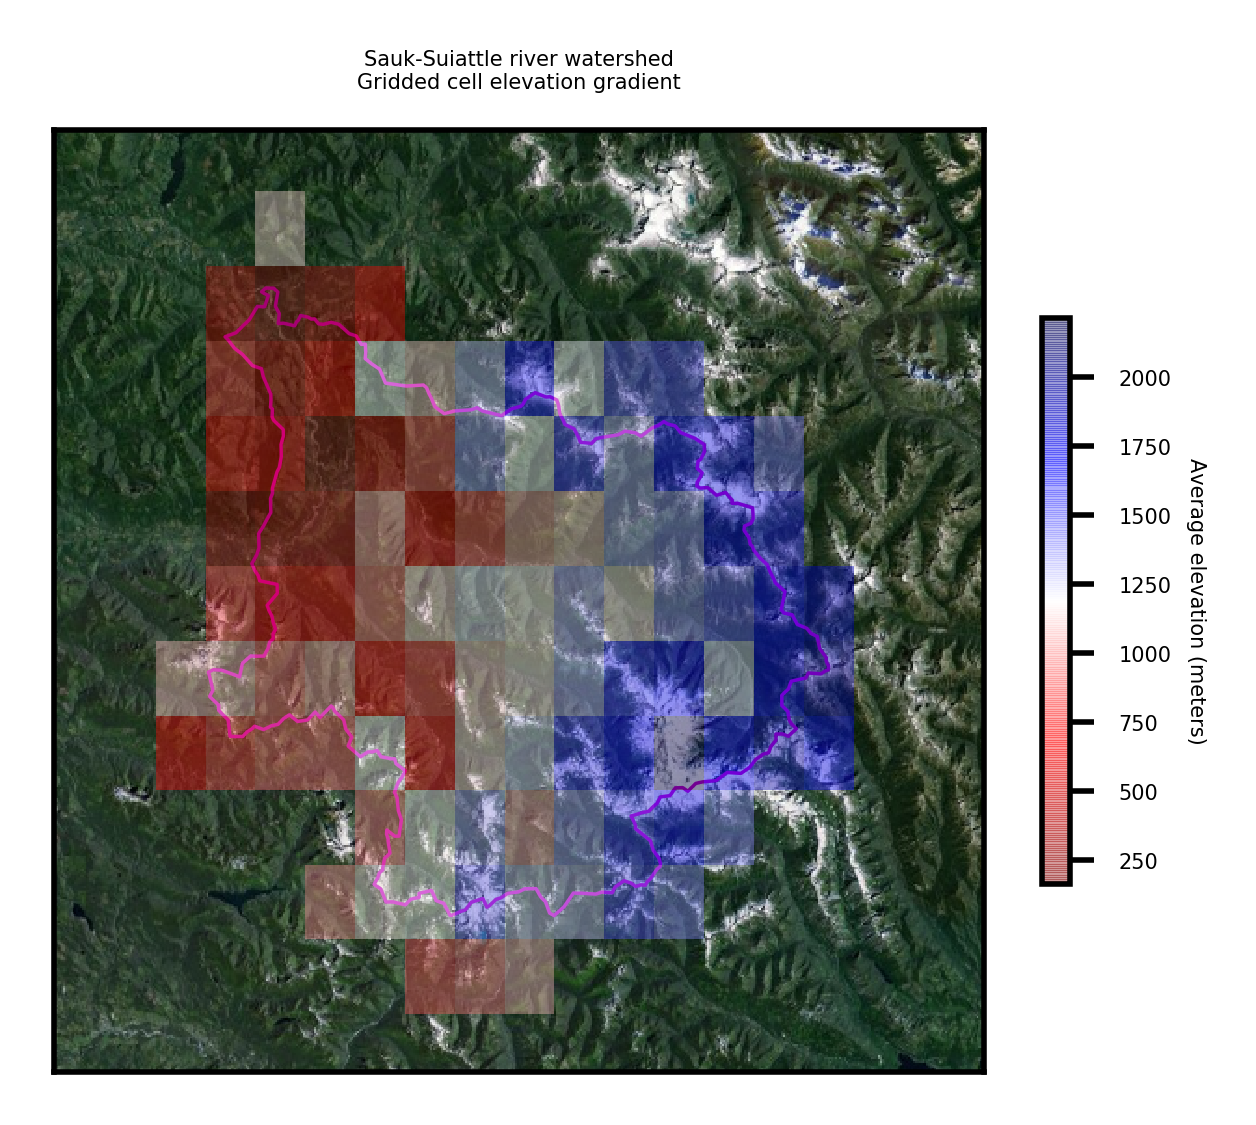

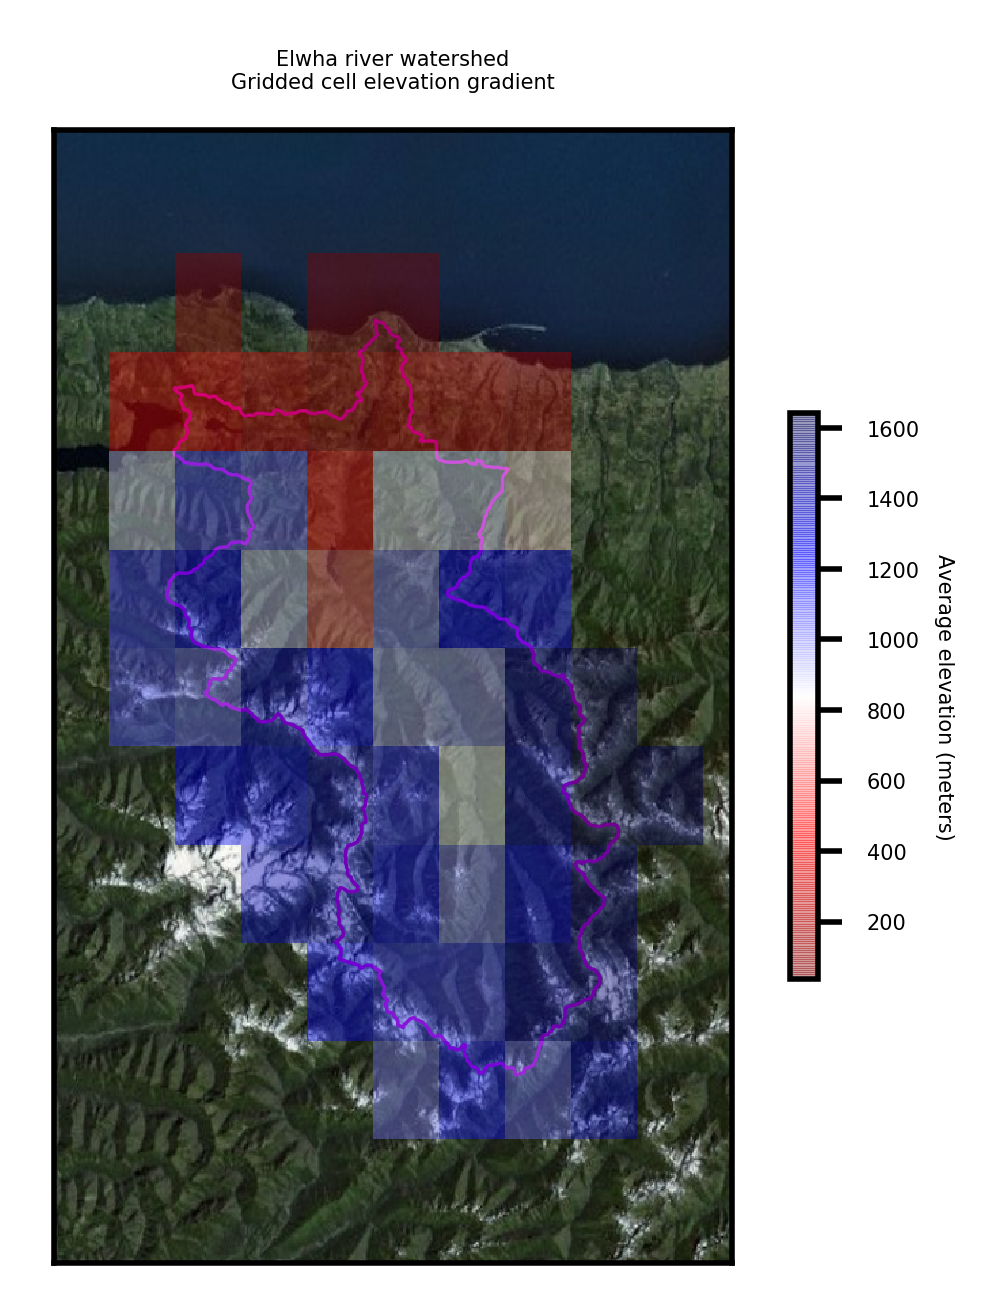

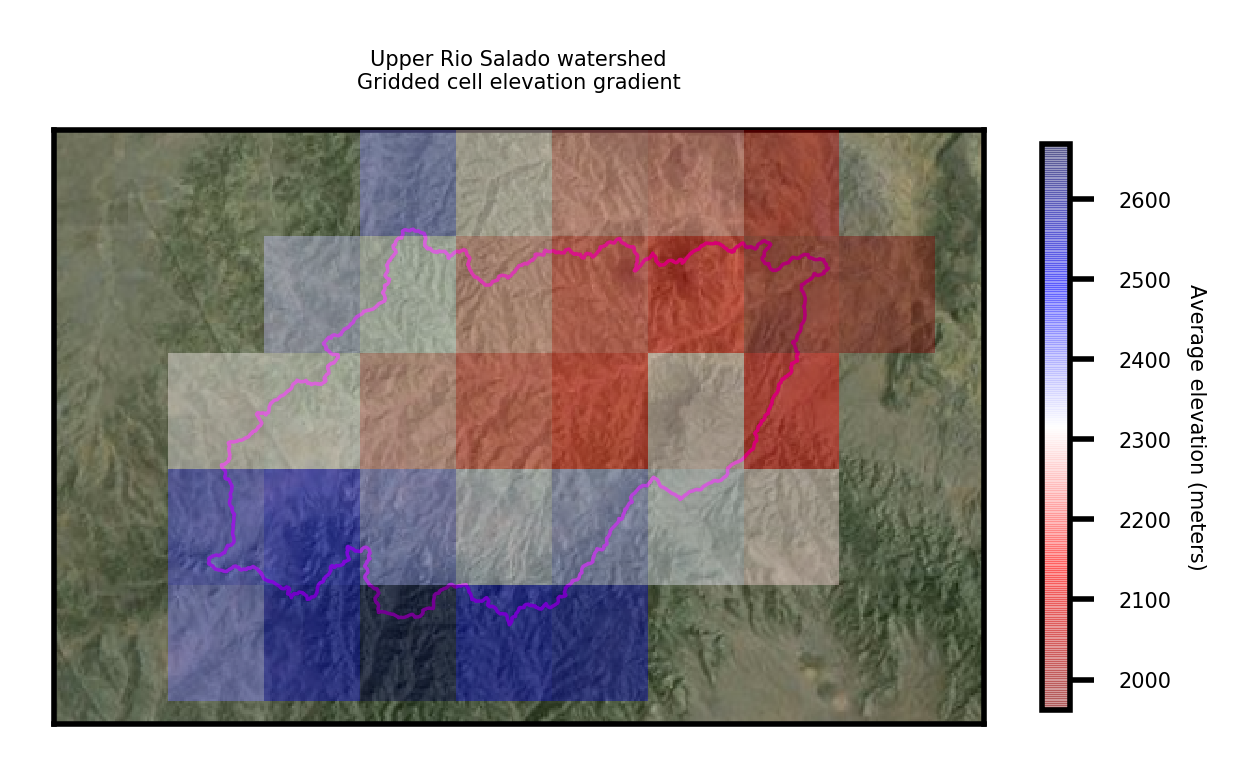

CPU times: user 51.8 s, sys: 10.6 s, total: 1min 2s
Wall time: 53.3 s


In [15]:
%%time 
# plot the watershed elevation gradient

for mappingfile, shp, sitename, outfilename in zip([mappingfile1, mappingfile2, mappingfile3],
                                                   [sauk, elwha, riosalado],
                                                   ['Sauk-Suiattle river','Elwha river','Upper Rio Salado'],
                                                   ['gcGradient_s.png', 'gcGradient_e.png', 'gcGradient_r.png']):

    # generate gridded Cell Gradient for the mappingfile ELEV variable
    ogh.griddedCellGradient(mappingfile=mappingfile, 
                            shapefile=shp.replace('.shp','_2.shp'),
                            outfilepath=os.path.join(homedir, outfilename),
                            plottitle='{0} watershed\nGridded cell elevation gradient'.format(sitename),
                            colorbar_label='Average elevation (meters)',
                            spatial_resolution=1/16, margin=0.25, epsg=3857, column='ELEV',
                            basemap_image='ESRI_Imagery_World_2D', cmap='seismic_r')


## 5. Save the results back into HydroShare
<a name="creation"></a>

Using the `hs_utils` library, the results of the Geoprocessing steps above can be saved back into HydroShare.  First, define all of the required metadata for resource creation, i.e. *title*, *abstract*, *keywords*, *content files*.  In addition, we must define the type of resource that will be created, in this case *genericresource*.  

***Note:*** Make sure you save the notebook at this point, so that all notebook changes will be saved into the new HydroShare resource.

In [16]:
# execute this cell to list the content of the directory
os.listdir(homedir)

['DREAM_dhsvm.csv',
 'Observatory_Sauk_Climate-012018.ipynb',
 'Observatory_Sauk_Climate_02202018.ipynb',
 'Observatory_Sauk_Climate_03062018.ipynb',
 'Observatory_Sauk_Climate_03072018.ipynb',
 'Observatory_Sauk_Climate_03072018_jp.ipynb',
 'Observatory_Sauk_Climate.ipynb',
 'Observatory_Sauk_Diagnosis.ipynb',
 'Observatory_Sauk_MetSimInputs_Python3.ipynb',
 'Observatory_Sauk_runDHSVM.ipynb',
 'Observatory_Skagit_Observed_Streamflow.ipynb',
 'ogh_meta.json',
 'ogh_meta_old.json',
 'ogh_old.py',
 'ogh.py',
 'Precip.daily.Liv2013m.txt',
 'Precip.daily.WRF.m.txt',
 'ThunderBasinSNOTEL.txt',
 'USC00455678.csv',
 '.ipynb_checkpoints',
 'eachwatershed.shp',
 'eachwatershed.shx',
 'eachwatershed.dbf',
 'eachwatershed.cpg',
 'eachwatershed.prj',
 'allwatersheds.shp',
 'allwatersheds.shx',
 'allwatersheds.dbf',
 'allwatersheds.cpg',
 'allwatersheds.prj',
 'statemap_annotated.png',
 'livneh2013',
 'livneh2015',
 'salathe2014',
 'Sauk_mappingfile.csv',
 'Elwha_mappingfile.csv',
 'RioSalado_mappi

## Archive the downloaded data files for collaborative use

Create list of files to save to HydroShare. Verify location and names.

In [ ]:
%%time
!tar -zcf livneh2013.tar.gz livneh2013
!tar -zcf livneh2015.tar.gz livneh2015
!tar -zcf salathe2014.tar.gz salathe2014

In [ ]:
ThisNotebook = os.path.join(notebookdir,'Observatory_usecase1.ipynb') #check name for consistency

climate2013_tar = os.path.join(homedir,'livneh2013.tar.gz')
climate2015_tar = os.path.join(homedir,'livneh2015.tar.gz')
wrf_tar = os.path.join(homedir,'salathe2014.tar.gz')
sauk_map = os.path.join(homedir,'Sauk_mappingfile.csv')
elwha_map = os.path.join(homedir,'Elwha_mappingfile.csv')
riosalado_map = os.path.join(homedir,'RioSalado_mappingfile.csv')
watershed_table = os.path.join(homedir, 'watershed_table.txt')

files=[ThisNotebook, sauk_map, elwha_map, riosalado_map, climate2013_tar, climate2015_tar, wrf_tar, watershed_table]

In [ ]:
# for each file downloaded onto the server folder, move to a new HydroShare Generic Resource
title = 'Results from testing out the TreatGeoSelf utility'
abstract = 'This the output from the TreatGeoSelf utility integration notebook.'
keywords = ['Sauk', 'Elwha','Rio Salado','climate','hydromet','watershed'] 
rtype = 'genericresource'

# create the new resource
resource_id = hs.createHydroShareResource(abstract, title,
                                          keywords=keywords, resource_type=rtype, content_files=files, public=False)